In [1]:
from interval import interval, inf, imath
import pandas as pd
import numpy as np

In [2]:
fb_gtf = pd.read_table('dmel-all-r6.27.gtf',sep='\t',header=None, 
                    names=['Chr','Database','Feature','Start','End','?', 'Strand','?.1', 'Attributes'])
fb_gtf.head()

,Chr,Database,Feature,Start,End,?,Strand,?.1,Attributes
0,X,FlyBase,gene,19961297,19969323,.,+,.,"gene_id ""FBgn0031081""; gene_symbol ""Nep3"";"
1,X,FlyBase,mRNA,19961689,19968479,.,+,.,"gene_id ""FBgn0031081""; gene_symbol ""Nep3""; tra..."
2,X,FlyBase,5UTR,19961689,19961845,.,+,.,"gene_id ""FBgn0031081""; gene_symbol ""Nep3""; tra..."
3,X,FlyBase,exon,19961689,19961845,.,+,.,"gene_id ""FBgn0031081""; gene_symbol ""Nep3""; tra..."
4,X,FlyBase,exon,19963955,19964071,.,+,.,"gene_id ""FBgn0031081""; gene_symbol ""Nep3""; tra..."


In [3]:
ids = []
for attr in fb_gtf['Attributes'].values:
    a =attr.split(" ")
    ids.append((a[1]).replace('"',"").replace(";",""))
ids[:3]
fb_gtf['Gene ID'] = ids


In [4]:
len(ids)

543554

In [5]:
exons = fb_gtf[fb_gtf['Feature']=='exon']
genes = exons.groupby('Gene ID')
gene_ids = exons['Gene ID'].unique()

In [6]:
exons.shape

(187818, 10)

In [7]:
len(gene_ids)

17529

In [8]:
exons.head()

,Chr,Database,Feature,Start,End,?,Strand,?.1,Attributes,Gene ID
3,X,FlyBase,exon,19961689,19961845,.,+,.,"gene_id ""FBgn0031081""; gene_symbol ""Nep3""; tra...",FBgn0031081
4,X,FlyBase,exon,19963955,19964071,.,+,.,"gene_id ""FBgn0031081""; gene_symbol ""Nep3""; tra...",FBgn0031081
5,X,FlyBase,exon,19964782,19964944,.,+,.,"gene_id ""FBgn0031081""; gene_symbol ""Nep3""; tra...",FBgn0031081
6,X,FlyBase,exon,19965006,19965126,.,+,.,"gene_id ""FBgn0031081""; gene_symbol ""Nep3""; tra...",FBgn0031081
7,X,FlyBase,exon,19965197,19965511,.,+,.,"gene_id ""FBgn0031081""; gene_symbol ""Nep3""; tra...",FBgn0031081


In [9]:
interval[1,8]
interval[4,13]

interval([4.0, 13.0])

In [10]:
##merge overlapping
interval[1,8]|interval[4,13]

interval([1.0, 13.0])

so based on this the total exon length would be 7+7 = 14
or 13+1 = 14

In [12]:
interval[6,15]|interval[9,13] ##9,13 is a subset of 6,15

interval([6.0, 15.0])

In [11]:
##merge non-overlapping
interval[1,3]|interval[4,13]

interval([1.0, 3.0], [4.0, 13.0])

In [12]:
interval[1]|interval[1,13]

interval([1.0, 13.0])

In [20]:
gene_ids[0]

'FBgn0031081'

In [13]:
"""merge overlapping exons for each gene and compute length"""
merged_regions = []
## iterate over each gene
for ID in gene_ids[:1]:
    
    df = genes.get_group(ID).sort_values(by='Start', ascending=True) ##sort by ascending order
    
    ##make interval then merge 
    consol_region = interval[df['Start'].values[0]] #set the initial value to start of the earliest exon
    
    ##iterate over each exon of a gene
    for i in range(df.shape[0]):
        #create an interval of an individual exon
        exon_size = interval[df['Start'].values[i],df['End'].values[i]] 
        consol_region= consol_region | exon_size  ##merge the exonsizes
    
    
    ##store region--process merged regions or make a dict by gene id to keep track
    merged_regions.append(consol_region)

In [14]:
df.shape

(27, 10)

In [17]:
consol_region

interval([19961297.0, 19961600.0], [19961689.0, 19961845.0], [19963176.0, 19963341.0], [19963955.0, 19964071.0], [19964782.0, 19964944.0], [19965006.0, 19965126.0], [19965197.0, 19965511.0], [19965577.0, 19966071.0], [19966183.0, 19967012.0], [19967081.0, 19967223.0], [19967284.0, 19969323.0])

In [20]:
print(consol_region[0])
print(consol_region[0][0])

(19961297.0, 19961600.0)
19961297.0


#### show that consol_region is correctly updating each time 

In [24]:
a = interval[6,15]|interval[9,13]
a

interval([6.0, 15.0])

In [25]:
b= interval[1,3]|interval[4,13]
b

interval([1.0, 3.0], [4.0, 13.0])

In [32]:
a|b

interval([1.0, 3.0], [4.0, 15.0])

#### interval a is a subset of interval b so the consol_region will be updated each each time to reflect that, pyinterval is so convenient

In [30]:
total_exon_length=0
for region in consol_region:
    total_exon_length+= region[1]-region[0]
total_exon_length    

4840.0

In [35]:
## load gene of nep3, exon lenght should exceed or even equal total gene lengtrh
nep3 = fb_gtf[fb_gtf['Gene ID']=='FBgn0031081'].query('Feature=="gene"')
nep3

,Chr,Database,Feature,Start,End,?,Strand,?.1,Attributes,Gene ID
0,X,FlyBase,gene,19961297,19969323,.,+,.,"gene_id ""FBgn0031081""; gene_symbol ""Nep3"";",FBgn0031081


In [75]:
nep3['End']-nep3['Start']

0    8026
dtype: int64

### now merge overlapping exons for eahc gene

In [41]:
"""merge overlapping exons for each gene and compute length"""
merged_regions = dict()
## iterate over each gene
for ID in gene_ids:
    df = genes.get_group(ID).sort_values(by='Start', ascending=True) ##sort by ascending order
    #set the initial value to start of the earliest exon
    consol_region = interval[df['Start'].values[0]] 
    ##iterate over exons of the gene
    for i in range(df.shape[0]):
        #create an interval of an individual exon region
        exon_size = interval[df['Start'].values[i],df['End'].values[i]] 
        ##consolidate overlapping the exon region
        consol_region= consol_region | exon_size  
    ##finally store  a list of non-overlapping exonic intervals of a gene
    merged_regions[ID]=consol_region
"""took 1.5minutes"""

In [50]:
##computed total_exon_size for drosophila
genes_total_exons=dict()
total_exon_length=0
for ID in gene_ids:
    consol_region = merged_regions[ID]
    total=0
    for region in consol_region:
        total+= region[1]-region[0]
    
    genes_total_exons[ID] = total  ##for my own use when I want to look exon sise distbtion
    total_exon_length +=total
total_exon_length

37338572.0

In [44]:
total_exon_length/1e6  ##YAASSS close to the reported 38.9Mb by the 2007 Assembly paper

37.338572

In [51]:
pd.DataFrame.from_dict(genes_total_exons,orient='index').reset_index().describe()

,0
count,17529.000000
mean,2130.102801
std,2482.923607
min,29.000000
25%,745.000000
50%,1424.000000
75%,2618.000000
max,71735.000000


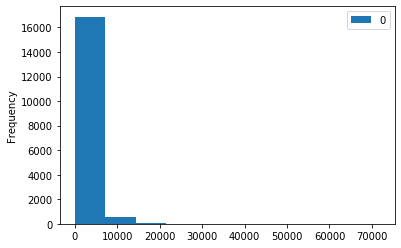

In [52]:
import matplotlib.pyplot as plt
pd.DataFrame.from_dict(genes_total_exons,orient='index').reset_index().plot.hist()
plt.show()

## I can re-use code to compute total UTR and Intron lengths

## Total 3'Prime UTR

In [53]:
three_prime_utr = fb_gtf[fb_gtf['Feature']=='3UTR']
genes = three_prime_utr.groupby('Gene ID')
gene_ids = three_prime_utr['Gene ID'].unique()
print(len(gene_ids))

13494


In [54]:
import time

In [57]:
s = time.time()
merged_regions = dict()
## iterate over each gene
for ID in gene_ids:
    df = genes.get_group(ID).sort_values(by='Start', ascending=True) ##sort by ascending order
    #set the initial value to start of the earliest three_prime_utr
    consol_region = interval[df['Start'].values[0]] 
    ##iterate over three_prime_UTR of the gene
    for i in range(df.shape[0]):
        #create an interval of an individual three_prime_utr region
        three_prime_utr_size = interval[df['Start'].values[i],df['End'].values[i]] 
        ##consolidate overlapping the three_prime_utr region
        consol_region= consol_region | three_prime_utr_size  
    ##store merged regions gene id to keep track
    merged_regions[ID]=consol_region
e = time.time()
print("Took {} minutes".format((e-s)/60.0))

Took 0.3438450853029887 minutes


In [58]:
genes_total_threeUTRs=dict()
total_threeUTR_length=0
for ID in gene_ids:
    consol_region = merged_regions[ID]
    total=0
    for region in consol_region:
        total+= region[1]-region[0]
    
    genes_total_threeUTRs[ID] = total  ##for my own use when I want to look threeUTR sise distbtion
    total_threeUTR_length +=total
total_threeUTR_length

7905198.0

### compute total genic, intergenic  total intron length

- gene_total - total_exons  
"" for flybase annotations UTRs are children of exons so exons lengths already include UTR""

In [59]:
genic = fb_gtf.query('Feature=="gene"')  ##keep in mind tRNAs are "gene" too

In [61]:
genic = fb_gtf.query('Feature=="gene"')  ##keep in mind tRNAs are "gene" too
genic_size = np.sum(genic['End']-genic['Start'])
genic_size

102174809

In [ ]:
genome_size=0
with open('./genomic_annotations_filer27/dmel-all-chromosome-r6.27.fasta', 'r') as f:
    for line in f:
        if line.startswith('>') is True:
            continue
        else:
            genome_size+=len(line)


In [63]:
genome_size

145523521

In [27]:
145523521 - 102174809

43348712

In [66]:
intergenic =genome_size-genic_size
intergenic/1e6

43.348712

In [67]:
intronic = genic_size - total_exon_length
intronic/1e6   ##according to 

64.836237

so introns account for greater genome occupancy than intergenic?  
The 2007 assembly paper reported 38.9Mb CDS to 21Mb of introns

According to Genome Biol. Evol. 1582–1598 doi:10.1093/gbe/evx103 model animals including drosophila have a 1:1 intronic:intergenic ratio

In [68]:
##intronic = intergenic - exonic ??
(intergenic - total_exon_length)/1e6

6.01014

### look at graham's result
- His tool finds introns based on the longest isoform of each gene 
### Graham's email 
I think for your purposes (if you just care about total intronic fraction), the simple approach of calculating the total exon/intron lengths is probably the least-fraught method

The first line of the file is a header with column descriptions, most of which are probably self-explanatory but here's a summary:

- name - custom naming scheme describing various attributes of the intron (gene, transcript, ordinal number, total, etc)
- region - chromosome/genomic location
- start - start coordinate (1-indexed)
- stop - stop coordinate (1-indexed)
- strand
- gene
- transcript
- length
- phase - where the intron occurs in the context of codons (only applies to introns defined by CDS features); phase 0 is between codons, phase 1 is after the first base of a codon, phase 2 is after the second
- index - ordinal position in the transcript, e.g. intron 4 of 5
- family_size - total number of introns in the parent transcript
- transcript_length - calculated using CDS features only when CDS features are present; if a transcript has only exons, then this reflects the total exonic sequence length
- fractional_position - the fractional position of the intron into the exonic sequence, e.g. an intron starting at base 200 of a transcript with 800 bp of exons would have a fractional position of 25.0
defined_by - feature used to define the intron. For example, this will be "exon" for any introns annotated in the - UTR of a given protein-coding transcript, but "cds" for the remaining introns.
dinucleotides - first and nt pairs of the intronic sequence
sequence_sha1 - a hash of the full intronic sequence (can be used to filter for duplicate intron sequences)
- unique_coords - whether the intron has identical coordinates to an intron in the longest isoform of each gene; introns from shorter isoforms will have this set to "N", as the longest isoform is prioritized when identifying introns

In [8]:
GL_data = pd.read_table('GL_drosophila_melanogaster.r6.27.info.iic', sep='\t')
GL_data.head()

,#name,region,start,stop,strand,gene,transcript,length,phase,index,family_size,transcript_length,fractional_position,defined_by,dinucleotides,sequence_sha1,unique_coords
0,DroMel-FBtr0308947@FBtr0308947-intron_1(1);[e],211000022278449,1188,1244,-,FBtr0308947,FBtr0308947,57,.,1,1,1051,37.203,exon,GC-AG,2c41b92f827989fcb42a9bd0a818a9b9dbbb0bb0,Y
1,DroMel-FBgn0085506@FBtr0302344-intron_1(1),211000022278760,815,868,-,FBgn0085506,FBtr0302344,54,2,1,1,261,4.215,cds,GT-AG,3f1bab12fd3f1c85fa1f20a463be3476ae78875b,Y
2,DroMel-FBgn0259817@FBtr0300105-intron_1(2),211000022279188,1490,1546,+,FBgn0259817,FBtr0300105,57,2,1,2,516,2.132,cds,GT-AG,d2eecacadbf7b7ea58ccffc1f03ba6ac81e3917f,Y
3,DroMel-FBgn0259817@FBtr0300105-intron_2(2),211000022279188,2048,2107,+,FBgn0259817,FBtr0300105,60,2,2,2,516,99.225,cds,GT-AG,1dc30099b86d20937e653892e90cad1488b007c9,Y
4,DroMel-FBgn0085692@FBtr0347010-intron_1(3),211000022280328,9381,9434,-,FBgn0085692,FBtr0347010,54,2,1,3,1317,3.341,cds,GT-AG,f418ded53d31752f8bddc4b512bc1fbbd05d96df,Y


In [72]:
GL_data.describe()

,start,stop,length,index,family_size,transcript_length,fractional_position
count,1.531820e+05,1.531820e+05,153182.000000,153182.000000,153182.000000,153182.000000,153182.000000
mean,1.308743e+07,1.308905e+07,1614.178363,5.630949,10.261898,3757.540357,45.815775
std,7.569702e+06,7.569665e+06,5803.018266,5.982248,9.015823,6079.585860,29.693552
min,8.150000e+02,8.680000e+02,2.000000,1.000000,1.000000,45.000000,0.031000
25%,7.232781e+06,7.234526e+06,63.000000,2.000000,5.000000,1374.000000,18.661250
50%,1.265479e+07,1.265517e+07,103.000000,4.000000,8.000000,2355.000000,43.563500
75%,1.876958e+07,1.877174e+07,747.000000,7.000000,13.000000,4098.000000,72.176500
max,3.206151e+07,3.206633e+07,268107.000000,81.000000,81.000000,68847.000000,99.981000


In [79]:
"""based on Graham's description I can sum the Length to get total intron size according to longest isoform"""
GL_data['length'].sum() / 1e6  

247.26307

In [80]:
1e6

1000000.0

### Whaaat! 240 Mb exceedes the total Dmel genome size

Graham:  
That's because that file includes redundant introns across multiple isoforms.

If you consider only those introns with "Y" in the last column, is that better?

In [94]:
GL_data.query('unique_coords== "Y"' )['length'].sum() / 1e6  

103.069162

In [97]:
intergenic+intronic  ##based on my calculations

108184949.0

In [96]:
103.069162+total_exon_length/1e6  ##essentially the genome size

140.407734

#### Sept 5 2019   
Graham and I met. 
- Graham says introns label [i] are not longest isoform.    
- Graham thinks my method of overlapping exons is biasing toward short introns which means this would bias toward the alternative hypothesis of non-random occurence of nested tRNAs in introns. I need to show that it isn't. 
- Also, Graham's tool may be finding "new" introns that are not annotated. I want to take the most conservative approach for defining intronic regions while being as as consistent as possible by sticking with the official reference genome annotation because my aim isn't intron discovery. 
### Proof of principle: I am going to make test intervals representing isoforms of the same gene and compare the final intron length

In [4]:
## Make a gene that is 65nt long with two isoforms
iso1 = interval([0,20],[42,59]) ## the intron lenght is 22 (range 20 to 42)
iso2= interval([0,20],[52,65]) ##  intron length is 31nt (range 20 to 52)
##according to Graham my approach biasing toward the smaller intron length of 22nt isoform 1. Lets see
iso1 | iso2

interval([0.0, 20.0], [42.0, 65.0])

In [5]:
##compute intron size
consol = (iso1 | iso2)
exon_len = 0
for region in consol:
    exon_len+= region[1]-region[0]
exon_len

43.0

In [7]:
65-exon_len

22.0

I stand corrected. So how can I modify my code to bias it toward longer intron but this comes at a trade-off of underestimating exons. I suppose since no tRNAs were found or predicted in coding sequence then it is excusable

In [9]:
GL_data.query('unique_coords== "Y"' )['length'].sum() / 1e6  

103.069162

Graham says introns label [i] are not longest isoform. Let's filter out them all

In [13]:
GL_data['#name'].values[0].split(';')[1]

'[e]'

In [22]:
not_long = [] ##stores indxies of not longest isoform
for i in range(GL_data.shape[0]):
    name =  GL_data['#name'].values[i]
    if '[i]' in name.split(';'):
        ##store the index to drop them later
        not_long.append(i)

In [23]:
len(not_long)

104907

In [25]:
##drop all the introns that do not belong to longest isoform
GL2 = GL_data.drop(not_long,axis=0)
GL2.shape  #48K seems about right

(48275, 17)

In [29]:
##recompute introns
GL2.query('unique_coords== "Y"' )['length'].sum() 

59387873

#### okay computing the total introns based on longest isoform is  this 59.38Mb looks reasonable for Dmel. I got 64b with my exon overlapping approach. However I trust the Flybase gtf annotation more

In [28]:
145523521 - 102174809 #total intergenic

43348712

In [31]:
102174809-37338572.0  #total intronic

64836237.0

In [36]:
genome = 145523521
intergenic = 43348712

In [30]:
np.log(43348712)

17.58478754910006

In [ ]:
np.log(43348712) 

In [32]:
np.log(64836237.0)

17.987375217984166

Similar to Woerhide that found 1:1 intron to intergeni ratio

In [34]:
43348712.0/64836237.0

0.6685877220172417

### load the trnascan predicted from each region 
#### 1. 3'UTR region and  5'UTR region 
- Given the small number I was able to visually inspect and verify their location using flybase's genome browswer
- as expected the 3UTR - on avergae longer - has more nested trnas than 5'UTR. 5UTR predicted a single low scoring pseudogene

In [100]:
tscan_3UTR = pd.read_table('./tse_output/dmel-all-three_prime_UTR-r6.27.fasta.tse.out',sep='\t',skiprows=1).reset_index(drop=True).drop(0,axis=0)
tscan_3UTR

,Name,tRNA #,Begin,End,Type,Codon,Begin.1,End.1,Score,Note
1,FBtr0345466,1,2226,2299,Thr,AGT,0,0,71.9,NaN
2,FBtr0301496,1,1212,1283,Pro,AGG,0,0,68.0,NaN
3,FBtr0301496,2,1005,934,Pro,AGG,0,0,68.0,NaN
4,FBtr0339901,1,97,168,Glu,CTC,0,0,72.7,NaN
5,FBtr0346438,1,775,704,Pro,CGG,0,0,69.5,NaN


In [102]:
##total size of 3UTR trnas
trnas_UTR = np.sum(np.abs(tscan_3UTR['End '].astype(int)- tscan_3UTR['Begin'].astype(int)))
trnas_UTR

357

In [103]:
##load the trna genes predicted from introns of the longest isoforms
tscan_intronic = pd.read_table('tscan_predicted_transc_introns.txt',sep='\t',skiprows=1).reset_index(drop=True).drop(0,axis=0)
tscan_intronic.head()

,Name,tRNA #,Begin,End,Type,Codon,Begin.1,End.1,Score,CM,Score.1,Note
1,FBgn0262867_intron_FBgn0262867:12_FBgn0262867:11,1,5450,5523,Asn,GTT,0,0,84.7,Asn,118.8,NaN
2,FBgn0262867_intron_FBgn0262867:12_FBgn0262867:11,2,5280,5207,Asn,GTT,0,0,84.7,Asn,118.8,NaN
3,FBgn0003716_intron_FBgn0003716:4_FBgn0003716:2,1,192,263,Asp,GTC,0,0,66.7,Asp,112.1,NaN
4,FBgn0003716_intron_FBgn0003716:4_FBgn0003716:2,2,603,532,Asp,GTC,0,0,56.7,Asp,102.9,NaN
5,FBgn0044020_intron_FBgn0044020:3_FBgn0044020:1,1,17571,17643,Met,CAT,0,0,82.4,Met,115.4,NaN


In [86]:
tscan_intronic=tscan_intronic[tscan_intronic['Note']!='pseudo'].drop('Note',axis=1)
tscan_intronic['Score'] = tscan_intronic['Score'].astype(float)
tscan_intronic = tscan_intronic[tscan_intronic['Score']>50]  ##remove low-quality trnas with covariance below 50
tscan_intronic.describe()

,Score
count,130.000000
mean,75.312308
std,8.331271
min,56.000000
25%,70.200000
50%,74.900000
75%,81.700000
max,88.800000


In [88]:
lengths = tscan_intronic['End'].astype(int) - tscan_intronic['Begin'].astype(int)
total_trna = np.sum(np.abs(lengths))
total_trna

9740

In [35]:
from scipy.stats import chisquare, binom_test

In [90]:
#compute net intronic region 
net_intronic = intronic -  total_trna
net_intronic

64826497.0

In [93]:
net_intronic/genome_size

0.44547092150141143

In [37]:
intergenic/genome_size

0.297881137716562

In [ ]:
# intergenic is 2/3 the size of intronic 

In [39]:
## in intronic is 
binom_test(x=130,n=290,p=0.45)   
#since total intron size is 44% of genome what is the expectation of nestinga trna?

1.0

### maybe better to l0ok at what fraction of introns are long enoguh to accomodate tRNAs since median and modal intron szie is 56nt ?
###based on my previous analysis the smallest intron hosting a trna was around 324nt

In [40]:
GL2.query('unique_coords== "Y"' )['length'].describe() 

count     47118.000000
mean       1260.407339
std        5841.731936
min           2.000000
25%          60.000000
50%          72.000000
75%         373.000000
max      268107.000000
Name: length, dtype: float64

In [43]:
sum_long_introns = GL2.query('unique_coords== "Y"' ).query('length >=300')['length'].sum()
sum_long_introns

56473680

In [44]:
sum_long_introns/genome

0.3880725233414329

In [45]:
binom_test(x=130,n=290,p=0.39)   

0.04679886211566328

#### use the intronic bed file from ensemble, store the longest intron for each transcript per gene
#### then eliminate intron sizes below 300nt